In [41]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd

import os
from auxiliary import values as v
from auxiliary.data.dataset_ht import find_group

import napari
from auxiliary.data.dataset_nuclei import NucleiDataset
from auxiliary.data.dataset_ht import HtDataset, find_group
from auxiliary.data import imaging


import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

matplotlib.rc("figure", figsize=(15, 5))
plt.style.use('default')

Create a DataFrame with the number of nuclei and membranes per group

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from auxiliary import values as v
from auxiliary.data.dataset_ht import HtDataset, find_group

# Dictionaries to store per-group and per-embryo data
nuclei_data = {}
membranes_data = {}

# Also create a list to store embryo-level data
embryo_records = []

for s in v.specimens_list:
    gr = find_group(s)
    print(s, gr)
    if gr == 'Gr10':
        continue
    try:
        ds = HtDataset(data_path=v.data_path)
        
        features_mem = ds.get_features(s, 'Membrane', 'myocardium', verbose=1, filtered=True)
        features_nu = ds.get_features(s, 'Nuclei', 'myocardium', verbose=1, filtered=True)
        
        membranes_count = len(features_mem)
        nuclei_count = len(features_nu)
        
        # Append embryo-level data record
        embryo_records.append({
            'Specimen': s,
            'Group': gr,
            'Nuclei': nuclei_count,
            'Membranes': membranes_count
        })
        
        # Store data into group-level lists
        if gr not in nuclei_data:
            nuclei_data[gr] = []
            membranes_data[gr] = []
        
        nuclei_data[gr].append(nuclei_count)
        membranes_data[gr].append(membranes_count)

    except Exception as e:
        print(e)
        continue

# Create a DataFrame with embryo-level data
df_embryos = pd.DataFrame(embryo_records)

# Compute mean and std per group
summary = {
    'Group': [],
    'NoSpecimens': [],
    'Nuclei_mean': [],
    'Nuclei_std': [],
    'Membranes_mean': [],
    'Membranes_std': []
}

for gr in sorted(nuclei_data.keys()):
    nuc_vals = nuclei_data[gr]
    mem_vals = membranes_data[gr]

    summary['Group'].append(gr)
    summary['NoSpecimens'].append(len(nuc_vals))
    summary['Nuclei_mean'].append(np.mean(nuc_vals))
    summary['Nuclei_std'].append(np.std(nuc_vals, ddof=1))
    summary['Membranes_mean'].append(np.mean(mem_vals))
    summary['Membranes_std'].append(np.std(mem_vals, ddof=1))

df_summary = pd.DataFrame(summary)

# Save summary DataFrame
df_summary.to_csv(v.data_path + 'FeaturesGeneral/group_cells.csv', index=False)

# Save embryo-level DataFrame
df_embryos.to_csv(v.data_path + 'FeaturesGeneral/embryo_cells.csv', index=False)

print("Summary DataFrame (group-level):")
print(df_summary.head())

print("Embryo-level DataFrame:")
print(df_embryos.head())

0806_E5 Gr1
	Found: 20190806_E5_cell_properties_radiomics_Membrane_myocardium_filtered.csv
	Found: 20190806_E5_cell_properties_radiomics_Nuclei_myocardium_filtered.csv
0504_E1 Gr1
	Found: 20190504_E1_cell_properties_radiomics_Membrane_myocardium_filtered.csv
	Found: 20190504_E1_cell_properties_radiomics_Nuclei_myocardium_filtered.csv
0208_E2 Gr1
	No directory: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr11/Features/Filtered
No specimen found: 0208_E2 (Get features) [Membrane - myocardium]
0521_E4 Gr1
	Found: 20190521_E4_cell_properties_radiomics_Membrane_myocardium_filtered.csv
	Found: 20190521_E4_cell_properties_radiomics_Nuclei_myocardium_filtered.csv
0521_E2 Gr1
	No directory: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr11/Features/Filtered
No specimen found: 0521_E2 (Get features) [Membrane - myocardium]
0516_E2 Gr2
	Found: 20190516_E2_cell_properties_radiomics_Membrane_myocardium_filtered.csv
	Found: 20190

In [50]:
df_summary = pd.read_csv(v.data_path + 'FeaturesGeneral/group_cells.csv')
df_embryos = pd.read_csv(v.data_path + 'FeaturesGeneral/embryo_cells.csv')

Time series analysis

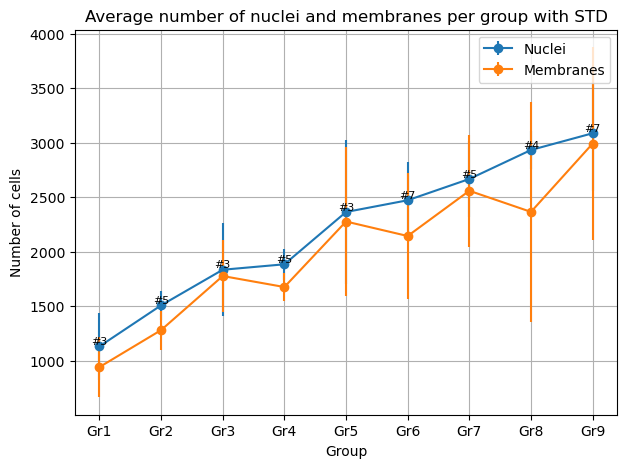

In [51]:
plt.figure(figsize=(7, 5))
plt.errorbar(
    df_summary['Group'], df_summary['Nuclei_mean'], 
    yerr=df_summary['Nuclei_std'], fmt='-o', label='Nuclei'
)
plt.errorbar(
    df_summary['Group'], df_summary['Membranes_mean'], 
    yerr=df_summary['Membranes_std'], fmt='-o', label='Membranes'
)

for i, row in df_summary.iterrows():
    plt.text(
        row['Group'], row['Nuclei_mean'], 
        f"#{row['NoSpecimens']}", ha='center', 
        va='bottom', fontsize=8
    )

plt.xlabel('Group')
plt.ylabel('Number of cells')
plt.title('Average number of nuclei and membranes per group with STD')
plt.grid(True)
plt.legend()
plt.show()


Ratio segmented nuclei/cell analysis

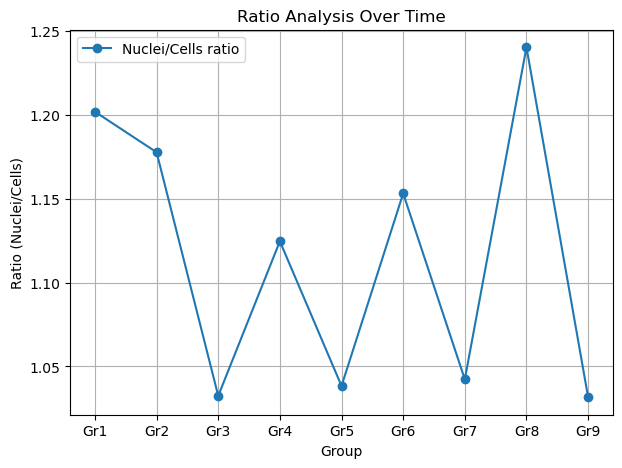

In [52]:
df_summary['Ratio'] = df_summary['Nuclei_mean'] / df_summary['Membranes_mean']

plt.figure(figsize=(7,5))
plt.plot(df_summary['Group'], df_summary['Ratio'], '-o', label='Nuclei/Cells ratio')
plt.xlabel('Group')
plt.ylabel('Ratio (Nuclei/Cells)')
plt.title('Ratio Analysis Over Time')
plt.grid(True)
plt.legend()
plt.show()


Lienar modeling

- Model: Nuclei = a*Membranes + b



Linear model: Nuclei = a*Membranes + b
a = 0.9958083227095912
b = 216.06370101820585


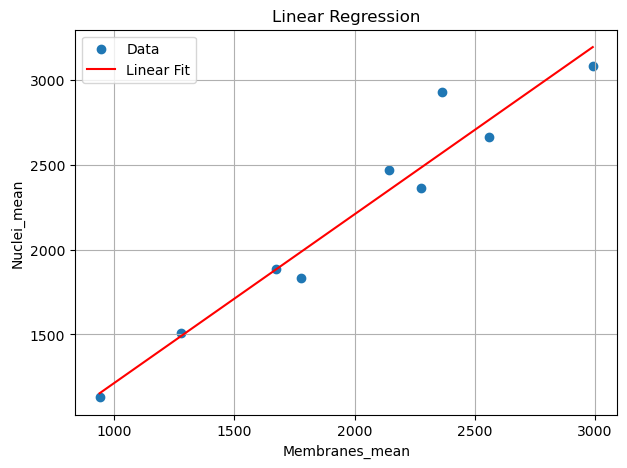

In [53]:
from sklearn.linear_model import LinearRegression

X = df_summary[['Membranes_mean']].values
y = df_summary['Nuclei_mean'].values

lin_reg = LinearRegression()
lin_reg.fit(X, y)

print("Linear model: Nuclei = a*Membranes + b")
print("a =", lin_reg.coef_[0])
print("b =", lin_reg.intercept_)

# Plot regression line
plt.figure(figsize=(7,5))
plt.scatter(df_summary['Membranes_mean'], df_summary['Nuclei_mean'], label='Data')
x_line = np.linspace(df_summary['Membranes_mean'].min(), df_summary['Membranes_mean'].max(), 100)
y_line = lin_reg.predict(x_line.reshape(-1,1))
plt.plot(x_line, y_line, 'r-', label='Linear Fit')
plt.xlabel('Membranes_mean')
plt.ylabel('Nuclei_mean')
plt.title('Linear Regression')
plt.grid(True)
plt.legend()
plt.show()


- Model: Nuclei = a*Group + b

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     373.2
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           2.48e-07
Time:                        10:47:11   Log-Likelihood:                -52.709
No. Observations:                   9   AIC:                             109.4
Df Residuals:                       7   BIC:                             109.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1011.7017     69.668     14.522      0.0

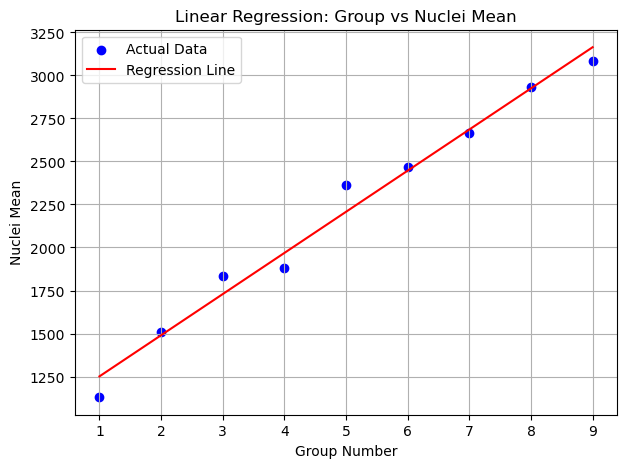

In [54]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Suppose 'df' is your DataFrame with the following columns:
# 'Group' (categorical or numerical), 'Nuclei_mean', 'Membranes_mean'
# Let's assume 'Group' is numerical or can be treated as a numeric time proxy.
# If 'Group' is not numeric, assign numeric indices or convert it appropriately.

# create a numeric index for regression:
df_summary['Group_num'] = df_summary['Group'].str.extract('(\d+)').astype(int)

# X is the independent variable (e.g., Group number as a proxy for time/stage)
X = df_summary['Group_num'].values

# y is the dependent variable (e.g., Nuclei_mean)
y = df_summary['Nuclei_mean'].values

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Fit an Ordinary Least Squares (OLS) regression
model = sm.OLS(y, X).fit()

# Print out the full statistical summary
print(model.summary())

X_groups = df_summary['Group_num']
y_actual = df_summary['Nuclei_mean']

# Generate a range of values for X to plot a smooth regression line
X_plot = np.linspace(X_groups.min(), X_groups.max(), 100)
X_plot_const = sm.add_constant(X_plot)
y_pred = model.predict(X_plot_const)

plt.figure(figsize=(7, 5))
plt.scatter(X_groups, y_actual, label='Actual Data', color='blue')
plt.plot(X_plot, y_pred, 'r-', label='Regression Line')

plt.xlabel('Group Number')
plt.ylabel('Nuclei Mean')
plt.title('Linear Regression: Group vs Nuclei Mean')
plt.grid(True)
plt.legend()
plt.show()

- R-squared: 0.982 suggests that about 98.2% of the variance in the dependent variable (y) is explained by the independent variable (Group). This is a very high value, indicating a strong linear relationship.

- Adj. R-squared: 0.979 is also very high, confirming the model is quite strong even after adjusting for the number of predictors.

- F-statistic: 373.2, p-value: 2.48e-07: The very low p-value means that the model is statistically significant; Group is a highly significant predictor of Nuclei_mean.

- Intercept (const) ~ 1011.7: When Group=0 (not a real scenario since your groups start at 1), predicted Nuclei_mean would be about 1011.7. This is just a baseline.

- Slope (x1) ~ 239.15: For each increment in Group number, the Nuclei_mean increases by about 239 cells on average.

- The confidence intervals [209.880, 268.429] for the slope do not include zero, reinforcing that the slope is significantly different from zero.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     128.5
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           4.60e-14
Time:                        10:49:44   Log-Likelihood:                -304.06
No. Observations:                  42   AIC:                             612.1
Df Residuals:                      40   BIC:                             615.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1021.7057    125.233      8.158      0.0

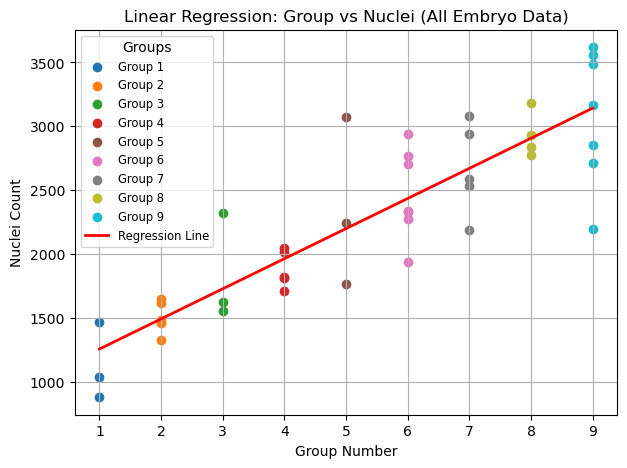

In [57]:
df_embryos['Group_num'] = df_embryos['Group'].str.extract('(\d+)').astype(int)

X = df_embryos['Group_num'].values
y = df_embryos['Nuclei'].values

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

groups = sorted(df_embryos['Group_num'].unique())
colors = plt.cm.tab10(np.linspace(0,1,len(groups)))
group_colors = dict(zip(groups, colors))

plt.figure(figsize=(7,5))
for g in groups:
    g_data = df_embryos[df_embryos['Group_num'] == g]
    plt.scatter(g_data['Group_num'], g_data['Nuclei'], color=group_colors[g], label=f'Group {g}')

# Regression line
X_plot = np.linspace(df_embryos['Group_num'].min(), df_embryos['Group_num'].max(), 100)
X_plot_const = sm.add_constant(X_plot)
y_pred = model.predict(X_plot_const)
plt.plot(X_plot, y_pred, 'r-', label='Regression Line', linewidth=2)

plt.xlabel('Group Number')
plt.ylabel('Nuclei Count')
plt.title('Linear Regression: Group vs Nuclei (All Embryo Data)')
plt.grid(True)
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys(), title='Groups', loc='best', fontsize='small')
plt.show()


- Model: Membranes = a*Group + b

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     73.74
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           5.78e-05
Time:                        10:48:06   Log-Likelihood:                -59.448
No. Observations:                   9   AIC:                             122.9
Df Residuals:                       7   BIC:                             123.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        875.8794    147.301      5.946      0.0

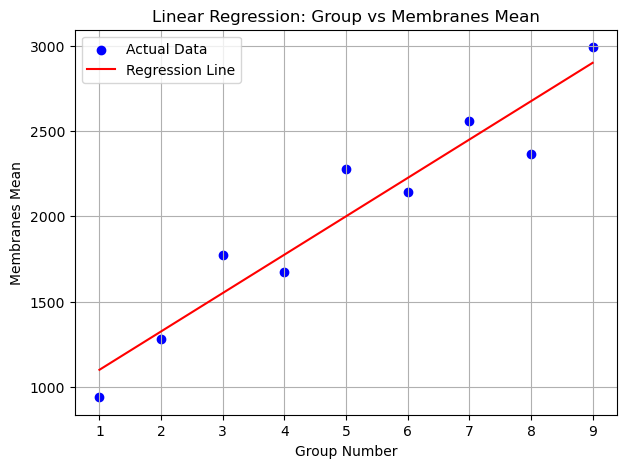

In [55]:
df_summary['Group_num'] = df_summary['Group'].str.extract('(\d+)').astype(int)

# X is the independent variable (e.g., Group number as a proxy for time/stage)
X = df_summary['Group_num'].values

# y is the dependent variable (e.g., Nuclei_mean)
y = df_summary['Membranes_mean'].values

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Fit an Ordinary Least Squares (OLS) regression
model = sm.OLS(y, X).fit()

# Print out the full statistical summary
print(model.summary())

X_groups = df_summary['Group_num']
y_actual = df_summary['Membranes_mean']

# Generate a range of values for X to plot a smooth regression line
X_plot = np.linspace(X_groups.min(), X_groups.max(), 100)
X_plot_const = sm.add_constant(X_plot)
y_pred = model.predict(X_plot_const)

plt.figure(figsize=(7, 5))
plt.scatter(X_groups, y_actual, label='Actual Data', color='blue')
plt.plot(X_plot, y_pred, 'r-', label='Regression Line')

plt.xlabel('Group Number')
plt.ylabel('Membranes Mean')
plt.title('Linear Regression: Group vs Membranes Mean')
plt.grid(True)
plt.legend()
plt.show()

- Model Fit Quality:
    R-squared (0.913): About 91.3% of the variance in the membranes count is explained by the group number. This is a high value, suggesting a strong linear relationship between the developmental group (as a proxy for time) and the membranes count.
    Adjusted R-squared (0.901): After adjusting for the number of predictors, the model still explains about 90.1% of the variance, indicating a robust fit.

- Statistical Significance:
    F-statistic (73.74) and p-value (5.78e-05): The very small p-value suggests that the overall linear model is statistically significant. It’s highly unlikely that this strong relationship is due to chance.

- Coefficients:
    Intercept (const = 875.8794): When the group index is zero (a hypothetical point before the earliest defined group), the model predicts approximately 876 membranes. While Group 0 does not exist in your actual experiment, this provides a baseline reference point.
    Slope (x1 = 224.7826): For each increment in the group number, the model predicts an increase of about 225 membranes on average. This is a substantial and highly significant effect, indicating that as you move through developmental time points (groups), the number of membranes consistently increases.

- Confidence Intervals and p-values:
    The 95% confidence interval for the slope is approximately [162.886, 286.679], which does not include zero. This reinforces that the slope is significantly different from zero.
    The low p-values for both the intercept and slope confirm that these estimates are statistically meaningful.

- Residual Diagnostics:
    Omnibus and Jarque-Bera tests: Both suggest no significant deviation from normality in the residuals, implying that the model’s assumptions about error distribution are not grossly violated.
    Durbin-Watson (2.901): This statistic is close to 3, which might indicate a slight negative autocorrelation in residuals, but given the small sample size (N=9), it is not too concerning. Still, it’s generally safer when DW is near 2 (no autocorrelation).

- Comparison to Nuclei Fit:
    While the fit for membranes is excellent (R²=0.913), the nuclei model had an even higher R² (0.982). This might reflect that nuclei counts are even more strongly or more consistently related to the developmental progression. The slightly lower R² for membranes could be due to segmentation underestimation or greater variability in identifying cell membranes.

Conclusion:
The linear regression model for membranes shows that the membranes count increases significantly as the groups progress. The relationship is strong, highly significant, and the model’s assumptions appear reasonable. Although slightly less perfect than the nuclei model’s fit, it still provides robust evidence that membranes also follow a roughly linear increase with developmental progression.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     43.56
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           6.80e-08
Time:                        10:51:37   Log-Likelihood:                -325.66
No. Observations:                  42   AIC:                             655.3
Df Residuals:                      40   BIC:                             658.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        842.4319    209.433      4.022      0.0

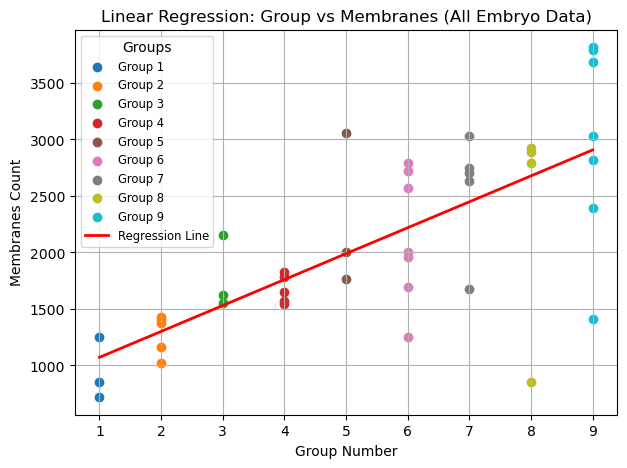

In [58]:
df_embryos['Group_num'] = df_embryos['Group'].str.extract('(\d+)').astype(int)

X = df_embryos['Group_num'].values
y = df_embryos['Membranes'].values

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

groups = sorted(df_embryos['Group_num'].unique())
colors = plt.cm.tab10(np.linspace(0,1,len(groups)))
group_colors = dict(zip(groups, colors))

plt.figure(figsize=(7,5))
for g in groups:
    g_data = df_embryos[df_embryos['Group_num'] == g]
    plt.scatter(g_data['Group_num'], g_data['Membranes'], color=group_colors[g], label=f'Group {g}')
    
# Regression line
X_plot = np.linspace(df_embryos['Group_num'].min(), df_embryos['Group_num'].max(), 100)
X_plot_const = sm.add_constant(X_plot)

y_pred = model.predict(X_plot_const)
plt.plot(X_plot, y_pred, 'r-', label='Regression Line', linewidth=2)

plt.xlabel('Group Number')
plt.ylabel('Membranes Count')
plt.title('Linear Regression: Group vs Membranes (All Embryo Data)')
plt.grid(True)
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys(), title='Groups', loc='best', fontsize='small')
plt.show()